In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns; sns.set()

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.datasets import make_moons
from sklearn.mixture import GaussianMixture as GMM

## Usando k-means

In [2]:
from sklearn.datasets._samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.6, random_state=0)

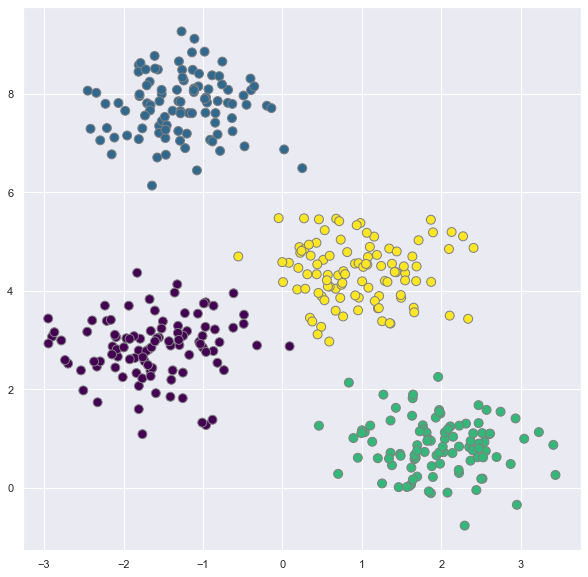

In [3]:
plt.figure(figsize=(10,10))
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)

plt.scatter(X[:,0], X[:,1], c=labels, s=80, cmap='viridis', edgecolors='gray')

In [4]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):

    plt.figure(figsize=(10,10))

    labels = kmeans.fit_predict(X)

    ax = ax or plt.gca()
    ax.axis('equal'), 
    ax.scatter(X[:,0], X[:,1], c=labels, s=80, cmap='viridis', edgecolors='gray', zorder=2)

    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]

    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

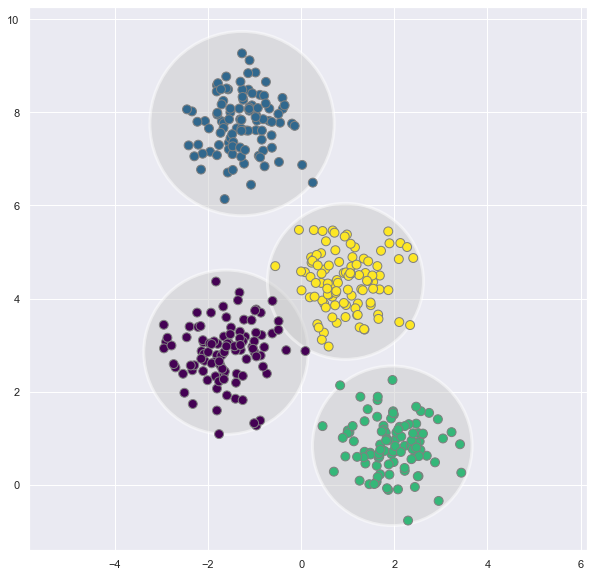

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

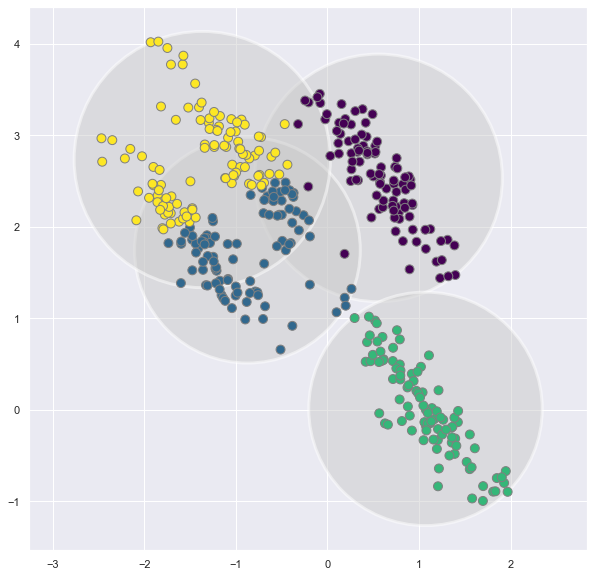

In [6]:
# Se transformar os dados para o formato elíptico

rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

## Gaussian Mixture Models

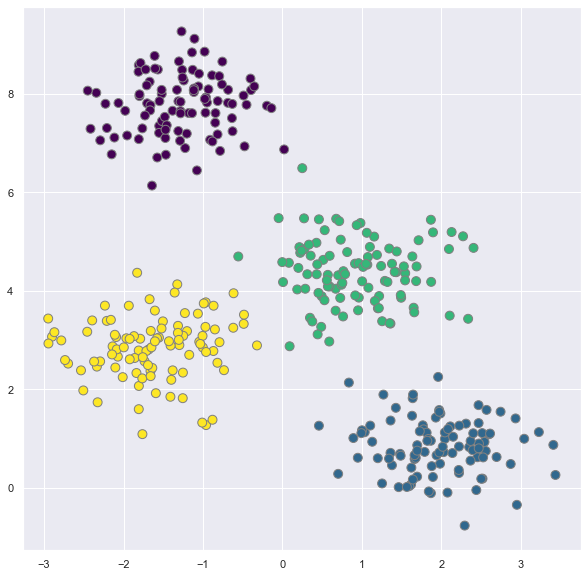

In [7]:
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)

plt.figure(figsize=(10,10))

plt.scatter(X[:,0], X[:,1], c=labels, s=80, cmap='viridis', edgecolors='gray')

In [8]:
# probabilidades
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.469 0.    0.531 0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]]


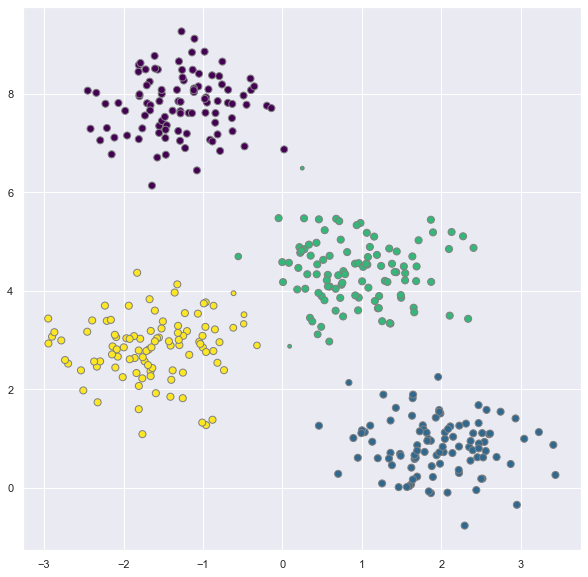

In [9]:
# mudar o tamanho do ponto de acordo com as probabilidades dadas
size = 50 * probs.max(1) ** 2
plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], c=labels, s=size, cmap='viridis', edgecolors='gray')

In [10]:
def draw_ellipse(position, covariance, ax=None, **kwargs):

    ax = ax or plt.gca()

    if covariance.shape == (2,2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1,0], U[0,0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    for nsig in range(1,4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

In [11]:
def plt_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()

    labels = gmm.fit_predict(X)
    if label:
        ax.scatter(X[:,0], X[:,1], c=labels, s=40, cmap='viridis', zorder=2, edgecolors='gray')
    else:
        ax.scatter(X[:,0], X[:,1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w*w_factor)

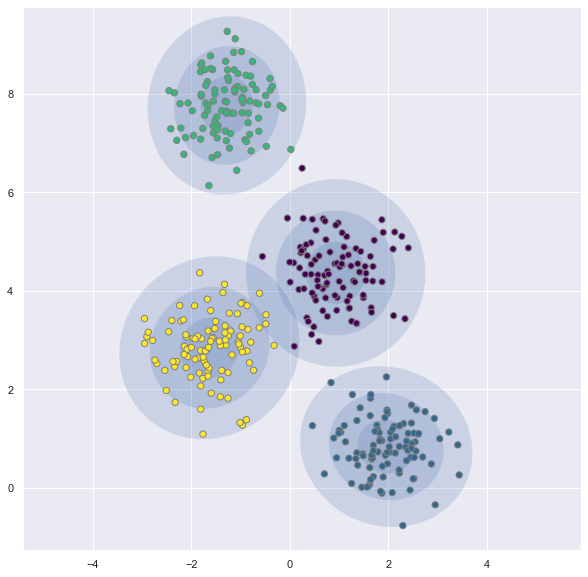

In [12]:
gmm = GMM(n_components=4, random_state=42)
plt.figure(figsize=(10,10))
plt_gmm(gmm, X)

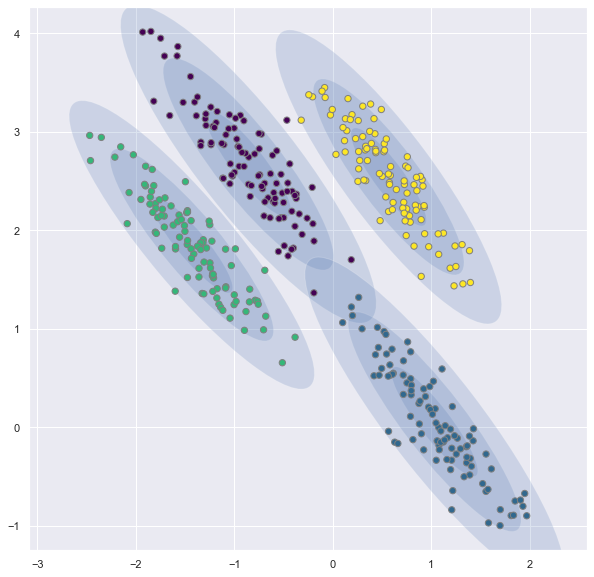

In [13]:
gmm = GMM(n_components=4, random_state=42, covariance_type='full')
plt.figure(figsize=(10,10))
plt_gmm(gmm, X_stretched)

## Estimação de densidade com GMM

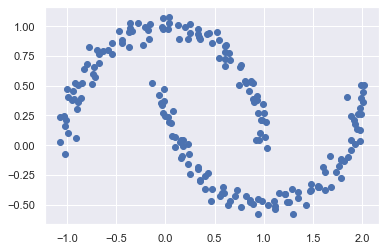

In [14]:
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:,0], Xmoon[:,1])

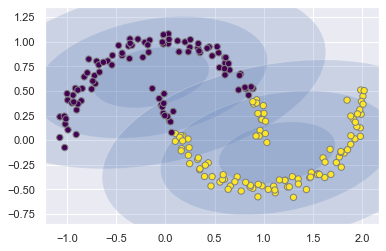

In [15]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plt_gmm(gmm2, Xmoon)

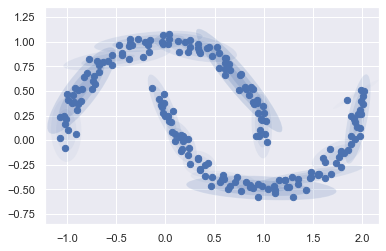

In [16]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plt_gmm(gmm16, Xmoon, label=False)

## Gerando novos dados com GMM

D:\Users\angel\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


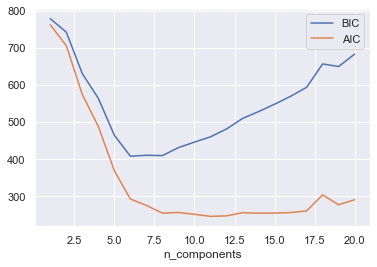

In [17]:
# AIC - Akaike information criterion (AIC)
# Bayesian information criterion (BIC)

n_components = np.arange(1,21)
models = [GMM(n, covariance_type='full', random_state= 0).fit(Xmoon) for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.show()

In [18]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA

In [19]:
digits = load_digits()
digits.data.shape

(1797, 64)

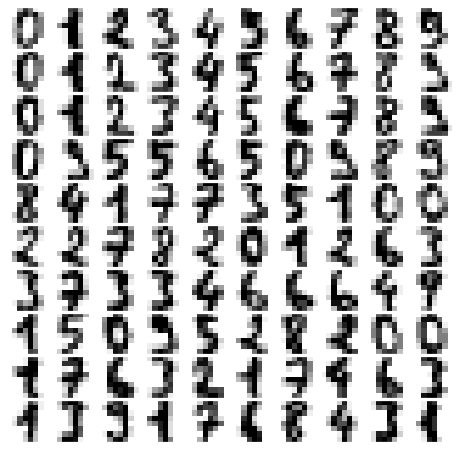

In [20]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8,8),
    subplot_kw=dict(xticks=[], yticks=[]))
    
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8,8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

In [21]:
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

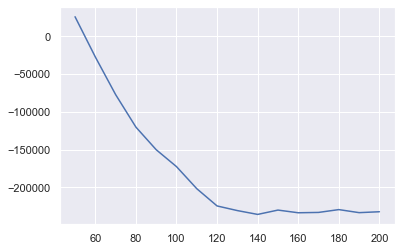

In [22]:
n_components = np.arange(50, 210, 10)
models = [GMM(n, covariance_type='full', random_state=0) for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics)

In [23]:
gmm = GMM(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [24]:
data_new = gmm.sample(100)
data_new[0].shape

(100, 41)

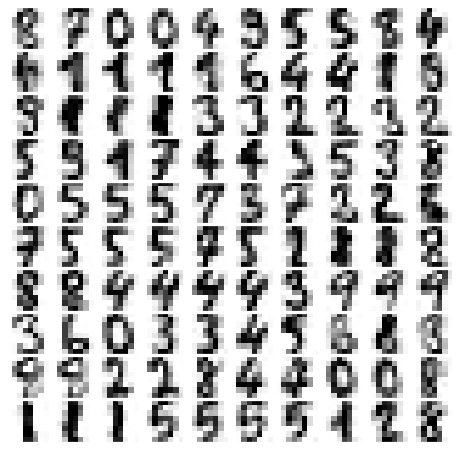

In [25]:
digits_new = pca.inverse_transform(data_new[0])
plot_digits(digits_new)

## Self Training

In [26]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

In [27]:
iris = load_iris()
X, y = shuffle(iris['data'], iris['target'], random_state=1000)
X.shape

(150, 4)

In [28]:
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [29]:
nb0 = GaussianNB()
nb0.fit(X, y)
print(classification_report(y, nb0.predict(X), target_names=iris['target_names']))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       0.94      0.94      0.94        50
   virginica       0.94      0.94      0.94        50

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



In [30]:
nb_samples = X.shape[0]
nb_labeled = 20

nb_unlabeled = nb_samples - nb_labeled
nb_unlabeled_samples = 2

X_train = X[:nb_labeled]
y_train = y[:nb_labeled]
X_unlabeled = X[nb_unlabeled:]

In [31]:
while X_train.shape[0] < nb_samples:

    nb = GaussianNB()
    nb.fit(X_train, y_train)

    if X_train.shape[0] == nb_samples or X_unlabeled.shape[0] == 0:
        break

    probs = nb.predict_proba(X_unlabeled)

    top_confidence_idxs = np.argsort(np.max(probs, axis=1)).astype(np.int64)[::-1]
    selected_idxs = top_confidence_idxs[0:nb_unlabeled]

    X_new_train = X_unlabeled[selected_idxs]
    y_new_train = nb.predict(X_new_train)

    X_train = np.concatenate((X_train, X_new_train), axis=0)
    y_train = np.concatenate((y_train, y_new_train), axis=0)

    X_unlabeled = np.delete(X_unlabeled, selected_idxs, axis=0)

In [32]:
print(classification_report(y, nb.predict(X), target_names=iris['target_names']))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       0.98      0.82      0.89        50
   virginica       0.84      0.98      0.91        50

    accuracy                           0.93       150
   macro avg       0.94      0.93      0.93       150
weighted avg       0.94      0.93      0.93       150



## Co-training

In [33]:
from sklearn.datasets import load_wine
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

import numpy as np
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.ensemble import GradientBoostingClassifier as gb

In [34]:
wine = load_wine()
X, y = shuffle(wine['data'], wine['target'], random_state=1000)

In [35]:
nb_samples = X.shape[0]
nb_labeled = 20
nb_unlabeled = nb_samples - nb_labeled
nb_unlabeled_samples = 2

feature_cut = 7
X_unlabeled = X[-nb_unlabeled:]
X_labeled = X[:nb_labeled]
y_labeled = y[:nb_labeled]
X_labeled_1 = X_labeled[:, 0:feature_cut]
X_labeled_2 = X_labeled[:, feature_cut:]

In [36]:
nb0 = GaussianNB()
nb0.fit(X_labeled, y_labeled)
print(classification_report(y, nb0.predict(X), target_names=wine['target_names']))

              precision    recall  f1-score   support

     class_0       1.00      0.51      0.67        59
     class_1       0.68      1.00      0.81        71
     class_2       1.00      0.92      0.96        48

    accuracy                           0.81       178
   macro avg       0.89      0.81      0.81       178
weighted avg       0.87      0.81      0.81       178



In [37]:
nb0 = gb()
nb0.fit(X_labeled, y_labeled)
print(classification_report(y, nb0.predict(X), target_names=wine['target_names']))

              precision    recall  f1-score   support

     class_0       1.00      0.78      0.88        59
     class_1       0.86      1.00      0.92        71
     class_2       0.96      0.98      0.97        48

    accuracy                           0.92       178
   macro avg       0.94      0.92      0.92       178
weighted avg       0.93      0.92      0.92       178



In [38]:
nb0 = rf()
nb0.fit(X_labeled, y_labeled)
print(classification_report(y, nb0.predict(X), target_names=wine['target_names']))

              precision    recall  f1-score   support

     class_0       0.96      0.78      0.86        59
     class_1       0.83      0.97      0.90        71
     class_2       1.00      0.98      0.99        48

    accuracy                           0.91       178
   macro avg       0.93      0.91      0.92       178
weighted avg       0.92      0.91      0.91       178



In [39]:
nb1 = None
nb2 = None

while X_labeled_1.shape[0] <= nb_samples:

    nb1 = GaussianNB()
    nb1.fit(X_labeled_1, y_labeled)

    nb2 = gb()
    nb2.fit(X_labeled_2, y_labeled)

    if X_labeled_1.shape[0] == nb_samples:
        break

    probs1 = nb1.predict_proba(X_unlabeled[:, 0:feature_cut])
    top_confidence_idxs1 = np.argsort(np.max(probs1, axis=1))[::-1]
    selected_idxs1 = top_confidence_idxs1[0:nb_unlabeled_samples]

    probs2 = nb2.predict_proba(X_unlabeled[:, feature_cut:])
    top_confidence_idxs2 = np.argsort(np.max(probs2, axis=1))[::-1]
    selected_idxs2 = top_confidence_idxs2[0:nb_unlabeled_samples]

    selected_idxs = list(selected_idxs1) + list(selected_idxs2)

    X_new_labeled = X_unlabeled[selected_idxs]
    X_new_labeled_1 = X_unlabeled[selected_idxs1, 0:feature_cut]
    X_new_labeled_2 = X_unlabeled[selected_idxs2, feature_cut:]

    y_new_labeled_1 = nb1.predict(X_new_labeled_1)
    y_new_labeled_2 = nb2.predict(X_new_labeled_2)

    X_labeled_1 = np.concatenate((X_labeled_1, X_new_labeled[:, 0:feature_cut]), axis=0)
    X_labeled_2 = np.concatenate((X_labeled_2, X_new_labeled[:, feature_cut:]), axis=0)
    y_labeled = np.concatenate((y_labeled, y_new_labeled_1, y_new_labeled_2), axis=0)

    X_unlabeled = np.delete(X_unlabeled, selected_idxs, axis=0)



In [40]:
print(classification_report(y, nb1.predict(X[:, 0:feature_cut]), target_names=wine['target_names']))

              precision    recall  f1-score   support

     class_0       1.00      0.19      0.31        59
     class_1       0.56      0.99      0.72        71
     class_2       0.98      0.88      0.92        48

    accuracy                           0.69       178
   macro avg       0.85      0.68      0.65       178
weighted avg       0.82      0.69      0.64       178



In [41]:
print(classification_report(y, nb2.predict(X[:, feature_cut:]), target_names=wine['target_names']))

              precision    recall  f1-score   support

     class_0       1.00      0.07      0.13        59
     class_1       0.54      1.00      0.70        71
     class_2       1.00      0.90      0.95        48

    accuracy                           0.66       178
   macro avg       0.85      0.65      0.59       178
weighted avg       0.82      0.66      0.58       178



In [48]:
nb_samples = X.shape[0]
nb_labeled = 20
nb_unlabeled = nb_samples - nb_labeled
nb_unlabeled_samples = 2

feature_cut = 7
X_unlabeled = X[-nb_unlabeled:]
X_labeled = X[:nb_labeled]
y_labeled = y[:nb_labeled]
X_labeled_1 = X_labeled[:, 0:feature_cut]
X_labeled_2 = X_labeled[:, feature_cut:]

In [49]:
nb1 = None
nb2 = None

while X_labeled_1.shape[0] <= nb_samples:

    nb1 = GaussianNB()
    nb1.fit(X_labeled_1, y_labeled)

    nb2 = rf()
    nb2.fit(X_labeled_2, y_labeled)

    if X_labeled_1.shape[0] == nb_samples:
        break

    probs1 = nb1.predict_proba(X_unlabeled[:, 0:feature_cut])
    top_confidence_idxs1 = np.argsort(np.max(probs1, axis=1))[::-1]
    selected_idxs1 = top_confidence_idxs1[0:nb_unlabeled_samples]

    probs2 = nb2.predict_proba(X_unlabeled[:, feature_cut:])
    top_confidence_idxs2 = np.argsort(np.max(probs2, axis=1))[::-1]
    selected_idxs2 = top_confidence_idxs2[0:nb_unlabeled_samples]

    selected_idxs = list(selected_idxs1) + list(selected_idxs2)

    X_new_labeled = X_unlabeled[selected_idxs]
    X_new_labeled_1 = X_unlabeled[selected_idxs1, 0:feature_cut]
    X_new_labeled_2 = X_unlabeled[selected_idxs2, feature_cut:]

    y_new_labeled_1 = nb1.predict(X_new_labeled_1)
    y_new_labeled_2 = nb2.predict(X_new_labeled_2)

    X_labeled_1 = np.concatenate((X_labeled_1, X_new_labeled[:, 0:feature_cut]), axis=0)
    X_labeled_2 = np.concatenate((X_labeled_2, X_new_labeled[:, feature_cut:]), axis=0)
    y_labeled = np.concatenate((y_labeled, y_new_labeled_1, y_new_labeled_2), axis=0)

    X_unlabeled = np.delete(X_unlabeled, selected_idxs, axis=0)

In [50]:
print(classification_report(y, nb1.predict(X[:, 0:feature_cut]), target_names=wine['target_names']))

              precision    recall  f1-score   support

     class_0       1.00      0.19      0.31        59
     class_1       0.56      0.99      0.72        71
     class_2       0.98      0.88      0.92        48

    accuracy                           0.69       178
   macro avg       0.85      0.68      0.65       178
weighted avg       0.82      0.69      0.64       178



In [51]:
print(classification_report(y, nb2.predict(X[:, feature_cut:]), target_names=wine['target_names']))

              precision    recall  f1-score   support

     class_0       1.00      0.07      0.13        59
     class_1       0.54      1.00      0.70        71
     class_2       1.00      0.90      0.95        48

    accuracy                           0.66       178
   macro avg       0.85      0.65      0.59       178
weighted avg       0.82      0.66      0.58       178

